In [123]:
import pandas as pd
import numpy as np
import seaborn as sb

In [124]:
# 한글깨짐 방지
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [125]:
# 법정동코드 불러오기
df_code = pd.read_table("data/법정동코드 전체자료.txt", sep='\t', encoding='cp949')
df_code.head(3)

,법정동코드,법정동명,폐지여부
0,1100000000,서울특별시,존재
1,1111000000,서울특별시 종로구,존재
2,1111010100,서울특별시 종로구 청운동,존재


In [319]:
# 읍면동 단위로 정제
chgnam_code = df_code[df_code['법정동코드'].apply(lambda x: str(x).startswith('44'))]
chgnam_code = chgnam_code[chgnam_code['폐지여부'] == '존재']
chgnam_code = chgnam_code[chgnam_code['법정동명'].apply(lambda x: x[-1] in ('읍', '면', '동'))]
chgnam_code.loc[:, '법정동코드'] = chgnam_code.loc[:, '법정동코드'].apply(lambda x: str(x)[:-2])
chgnam_code.reset_index(drop=True, inplace=True)
chgnam_code.drop(columns='폐지여부', inplace=True)
print(len(chgnam_code))
chgnam_code.head(3)

285


,법정동코드,법정동명
0,44131101,충청남도 천안시 동남구 대흥동
1,44131102,충청남도 천안시 동남구 성황동
2,44131103,충청남도 천안시 동남구 문화동


In [127]:
# 라벨링된 출동데이터에서 필요한 컬럼만 선별
df_res = pd.read_excel('data/labeled.xlsx')
df_res['법정동명'] = df_res['발생장소_시'] + " " + df_res['발생장소_구'] + " " + df_res['발생장소_동']
df_res = df_res.loc[:, ['신고시간', '발생장소_시', '발생장소_구', '발생장소_동', '법정동명', '특보종류', '1-연관 / 0-비연관']]
df_res.head(3)

,신고시간,발생장소_시,발생장소_구,발생장소_동,법정동명,특보종류,1-연관 / 0-비연관
0,2014-08-25 07:29:00,충청남도,부여군,규암면,충청남도 부여군 규암면,호우주의보,0
1,2014-08-25 10:00:00,충청남도,부여군,장암면,충청남도 부여군 장암면,호우주의보,0
2,2014-08-25 10:39:00,충청남도,부여군,구룡면,충청남도 부여군 구룡면,호우주의보,0


<Axes: xlabel='1-연관 / 0-비연관'>

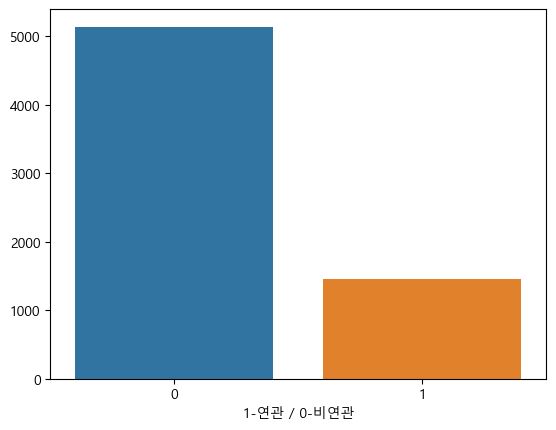

In [128]:
# 라벨 비율 확인: 이 정도 비율이면 샘플링 없이 돌려도 될것으로 보임
label_dis = df_res['1-연관 / 0-비연관'].value_counts()
sb.barplot(x=label_dis.index, y=label_dis.values)

In [129]:
# 법정동코드와 출동데이터 merge
df_full = pd.merge(chgnam_code, df_res, on='법정동명', how='outer')
df_full.head(3)

,법정동코드,법정동명,신고시간,발생장소_시,발생장소_구,발생장소_동,특보종류,1-연관 / 0-비연관
0,44131101,충청남도 천안시 동남구 대흥동,2019-07-25 10:14:00,충청남도,천안시 동남구,대흥동,호우경보,0.0
1,44131101,충청남도 천안시 동남구 대흥동,2019-07-25 10:14:00,충청남도,천안시 동남구,대흥동,호우경보,0.0
2,44131101,충청남도 천안시 동남구 대흥동,2020-08-04 03:09:00,충청남도,천안시 동남구,대흥동,호우경보,0.0


In [130]:
# 쌍용2동,3동이 합쳐져 있고(44133107) 1동이 일반 쌍용동(44131117)
df_full.loc[df_full['발생장소_동'] == '쌍용2동', '법정동코드'] = '44133107'
df_full.loc[df_full['발생장소_동'] == '쌍용3동', '법정동코드'] = '44133107'
df_full.loc[df_full['발생장소_동'] == '쌍용1동', '법정동코드'] = '44131117'

In [131]:
# 성정1동,2동,성정동은 하나의 성정동 
df_full.loc[df_full['발생장소_동'] == '성정1동', '법정동코드'] = '44133102'
df_full.loc[df_full['발생장소_동'] == '성정2동', '법정동코드'] = '44133102'

In [132]:
# 온양1동은 온천동에 포함됨(44200101)
df_full.loc[df_full['발생장소_동'] == '온양1동', '법정동코드'] = '44200101'

In [133]:
# 홍북면은 홍북읍과 같은 지역(44800256)
df_full.loc[df_full['발생장소_동'] == '홍북면', '법정동코드'] = '44800256'

In [134]:
# 부춘동은 서산시 갈산동(44210103), 읍내동(44210101)을 합친 지역-> 일단은 읍내동으로 판단 (인구밀도가 높기 때문)
df_full.loc[df_full['발생장소_동'] == '부춘동', '법정동코드'] = '44210101'

In [135]:
# 결측치 제거
df_full = df_full.dropna(axis=0)

In [136]:
# 필요없는 컬럼 제거
df_full = df_full.drop(columns=['법정동명', '발생장소_시', '발생장소_동'])

In [137]:
# 인덱스 리셋
df_full = df_full.reset_index(drop=True)
df_full.head(3)

,법정동코드,신고시간,발생장소_구,특보종류,1-연관 / 0-비연관
0,44131101,2019-07-25 10:14:00,천안시 동남구,호우경보,0.0
1,44131101,2019-07-25 10:14:00,천안시 동남구,호우경보,0.0
2,44131101,2020-08-04 03:09:00,천안시 동남구,호우경보,0.0


In [138]:
# 특정컬럼 분해
df_full['일시'] = df_full['신고시간'].apply(lambda x: pd.to_datetime(str(x).split()[0]))
df_full['지점명'] = df_full['발생장소_구'].apply(lambda x: str(x)[:2])
df_full = df_full.loc[:, ['법정동코드', '신고시간', '일시', '발생장소_구', '지점명', '특보종류', '1-연관 / 0-비연관']]
df_full.head(3)

,법정동코드,신고시간,일시,발생장소_구,지점명,특보종류,1-연관 / 0-비연관
0,44131101,2019-07-25 10:14:00,2019-07-25,천안시 동남구,천안,호우경보,0.0
1,44131101,2019-07-25 10:14:00,2019-07-25,천안시 동남구,천안,호우경보,0.0
2,44131101,2020-08-04 03:09:00,2020-08-04,천안시 동남구,천안,호우경보,0.0


In [139]:
# 날씨데이터 가져오기
df_wea = pd.read_excel('data/충남 15개 지점 일값 자료.xlsx', sheet_name=None, engine='openpyxl')

In [140]:
# 불필요 컬럼 제거 및 이름 변경
del df_wea['서산 등 5개 지점 일값자료']
df_wea = pd.concat(df_wea.values())
df_wea = df_wea.drop(columns=['지점', '최대 순간풍속 시각(hhmi)', '최대 순간 풍속 풍향(16방위)', '최대 순간 풍속 풍향(deg)'])
df_wea = df_wea.rename(columns={
    '평균기온(°C)': 'avg_temp', '최저기온(°C)': 'min_temp', '최고기온(°C)': 'max_temp', 
    '일강수량(mm)': 'day_pre', '최대 순간 풍속(m/s)': 'max_wspeed', '평균 풍속(m/s)': 'avg_wspeed'
})
df_wea.head(3)

,지점명,일시,avg_temp,min_temp,max_temp,day_pre,max_wspeed,avg_wspeed
0,서산,2014-01-01,3.0,-4.6,9.3,NaN,12.6,2.5
1,서산,2014-01-02,0.7,-4.8,7.8,NaN,7.4,0.8
2,서산,2014-01-03,2.3,-4.3,9.6,NaN,5.5,1.1


In [203]:
df_wea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54082 entries, 0 to 3639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   지점명         54082 non-null  object        
 1   일시          54082 non-null  datetime64[ns]
 2   avg_temp    53884 non-null  float64       
 3   min_temp    53898 non-null  float64       
 4   max_temp    53902 non-null  float64       
 5   day_pre     41041 non-null  float64       
 6   max_wspeed  53857 non-null  float64       
 7   avg_wspeed  53705 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 3.7+ MB


In [205]:
# 라벨데이터랑 merge후 결측치 확인 
df_x = pd.merge(left=df_full, right=df_wea, on=['지점명', '일시'], how='left')
df_x['year'] = df_x['일시'].dt.year
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6597 entries, 0 to 6596
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   법정동코드         6597 non-null   object        
 1   신고시간          6597 non-null   datetime64[ns]
 2   일시            6597 non-null   datetime64[ns]
 3   발생장소_구        6597 non-null   object        
 4   지점명           6597 non-null   object        
 5   특보종류          6597 non-null   object        
 6   1-연관 / 0-비연관  6597 non-null   float64       
 7   avg_temp      6460 non-null   float64       
 8   min_temp      6464 non-null   float64       
 9   max_temp      6471 non-null   float64       
 10  day_pre       6415 non-null   float64       
 11  max_wspeed    6430 non-null   float64       
 12  avg_wspeed    6413 non-null   float64       
 13  year          6597 non-null   int32         
dtypes: datetime64[ns](2), float64(7), int32(1), object(4)
memory usage: 695.9+ KB


In [199]:
# 결측값 처리 함수
# 결측값이 아니면서 동일년도 +0, +1, +2 이면서 특보종류 같은 항목의 평균값으로 대체
def handle_na(df, col):
    for idx in list(df.loc[df[col].isna()].index):
        if pd.isna(df.loc[idx, col]):
            df.loc[idx, col] = df_x.loc[(
                ~df[col].isna()) & 
                (df['특보종류'] == df.loc[idx, "특보종류"]) & 
                ((df['year'] == df.loc[idx, "year"] + 1) | 
                (df['year'] == df.loc[idx, "year"] + 2) |
                (df['year'] == df.loc[idx, "year"])), col
            ].mean()



In [206]:
# 결측값 전부 처리
for col in ["avg_temp", "min_temp", "max_temp", "day_pre", "max_wspeed", "avg_wspeed"]:
    handle_na(df_x, col)

In [305]:
# 인구데이터 처리
df_pop = pd.read_excel("data/population_full.xlsx")
df_pop['발생장소_동'] = df_pop['발생장소_동'].apply(lambda x: x.lstrip())

In [306]:
df_pop['법정동명'] = df_pop['발생장소_시'] + " " + df_pop['발생장소_구'] + " " + df_pop['발생장소_동']

In [312]:
code_set = set(chgnam_code['법정동명'].values)
pop_set = set(df_pop['법정동명'].values)

In [265]:
A = set.difference(code_set, pop_set)

In [267]:
with open("unmatched.txt", "w") as f:
    for address in A:
        f.write(address + "\n")

In [313]:
intersection = list(set.intersection(code_set, pop_set))

In [320]:
for i in range(2014, 2024):
    chgnam_code[i] = 0

In [334]:
for address in intersection:
    #print(address)
    for i in range(2014, 2024):
        #print(df_pop.loc[df_pop['법정동명'] == address, i].tolist())
        chgnam_code.loc[
            chgnam_code['법정동명'] == address, i
        ] = df_pop.loc[df_pop['법정동명'] == address, i].tolist()[0]
    # print(df_pop.loc[df_pop['법정동명'] == address, [i for i in range(2014, 2024)]])

In [337]:
chgnam_code.to_excel('saved.xlsx')

In [335]:
chgnam_code

,법정동코드,법정동명,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,44131101,충청남도 천안시 동남구 대흥동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,44131102,충청남도 천안시 동남구 성황동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44131103,충청남도 천안시 동남구 문화동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44131104,충청남도 천안시 동남구 사직동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44131105,충청남도 천안시 동남구 영성동,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
280,44825320,충청남도 태안군 남면,4408.0,4599.0,4669.0,4639.0,4682.0,4589.0,4363.0,4278.0,4206.0,4271.0
281,44825330,충청남도 태안군 근흥면,5785.0,5714.0,5686.0,5708.0,5642.0,5481.0,5386.0,5412.0,5395.0,5363.0
282,44825340,충청남도 태안군 소원면,5691.0,5651.0,5595.0,5557.0,5490.0,5390.0,5372.0,5365.0,5349.0,5287.0
283,44825350,충청남도 태안군 원북면,4993.0,5002.0,4584.0,4601.0,4579.0,4521.0,4433.0,4345.0,4373.0,4374.0
